# Exploratory Data Analysis (MC2)

This notebook provides an exploratory analysis of the cleaned knowledge graph, aiming to uncover key insights through descriptive statistics and preliminary visualizations. We leverage Python libraries such as Matplotlib, Seaborn, and Altair to summarize the data, examine distributions, and identify patterns across entities, relationships, and attributes.

In [24]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt

### Load .json data and convert it to CSV

In [25]:
# Load .json data and read it as pandas DataFrame
folder_path = '../data/'

with open(folder_path + 'commodities.json') as f:
    commodities = pd.json_normalize(json.load(f))

with open(folder_path + 'vessels.json') as f:
    vessels = pd.json_normalize(json.load(f))

with open(folder_path + 'locations.json') as f:
    locations = pd.json_normalize(json.load(f))

with open(folder_path + 'documents.json') as f:
    documents = pd.json_normalize(json.load(f))

with open(folder_path + 'transponder_pings.json') as f:
    transponder_pings = pd.json_normalize(json.load(f))

with open(folder_path + 'harbor_reports.json') as f:
    harbor_reports = pd.json_normalize(json.load(f))

with open(folder_path + 'transactions.json') as f:
    transactions = pd.json_normalize(json.load(f))

Read timestamps

In [26]:
# Convert timestamps to datetime
transponder_pings['time'] = pd.to_datetime(transponder_pings['time'], errors='coerce')
transactions['date'] = pd.to_datetime(transactions['date'], errors='coerce')
harbor_reports['date'] = pd.to_datetime(harbor_reports['date'], errors='coerce')

# Convert dwell to numbers
transponder_pings['dwell'] = pd.to_numeric(transponder_pings['dwell'], errors='coerce')
transponder_pings['dwell_hours'] = pd.to_numeric(transponder_pings['dwell_hours'], errors='coerce')
transponder_pings['dwell_days'] = pd.to_numeric(transponder_pings['dwell_days'], errors='coerce')

Merge data

In [27]:
# Merge vessels with transponder pings to get vessel information: left_on = 'target', right_on = 'id', drop 'id' from merged df to avoid redundancy
transponder_pings_merged = transponder_pings.merge(
    vessels,
    left_on="target",
    right_on="id",
    how="inner", # keep only pings that have a corresponding vessel
    validate="many_to_one" # each ping has one vessel, but each vessel can have many pings
).drop(columns=["id"])

# Merge vessels with harbor reports to get vessel information: left_on = 'source', right_on = 'id', drop 'id' from merged df to avoid redundancy
harbor_reports_merged = harbor_reports.merge(
    vessels,
    left_on="source",
    right_on="id",
    how="inner", 
    validate="many_to_one"
).drop(columns=["id"])

# Merge documents with transactions to get document information: left_on = 'source', right_on = 'id', drop 'id' from merged df to avoid redundancy
transactions_merged = transactions.merge(
    documents,
    left_on="source",
    right_on="id",
    how="inner", 
    validate="many_to_one"
).drop(columns=["id"])

Let's analyze **dwell time** by vessel type and source location:

In [28]:
print(transponder_pings_merged.groupby('vessel_type')['dwell_hours'].describe().to_string())

                    count       mean        std       min       25%       50%       75%          max
vessel_type                                                                                         
CargoVessel        6239.0   4.950617   9.392983  0.000000  0.958439  2.008782  4.449028   150.697783
Ferry.Cargo        2299.0   5.886577  19.056124  0.000000  1.097232  1.609811  2.950762   152.176139
Ferry.Passenger    9472.0   1.912313   8.470539  0.000000  0.583043  0.851157  1.137924    96.813893
FishingVessel    227957.0   5.385989  11.663285  0.000000  1.354728  1.798011  3.451696   287.526087
Other              2586.0  13.949763  32.840011  0.678852  1.709971  2.592924  8.916125   569.431097
Research           2498.0   5.464061  21.624417  0.000000  0.743886  0.940313  1.280211   153.759645
Tour               7491.0  10.704628  94.647188  0.000000  0.558690  1.479703  6.976896  7982.034120


In [29]:
print(transponder_pings_merged.groupby('source')['dwell_hours'].describe().to_string())

                       count       mean        std       min        25%        50%        75%          max
source                                                                                                    
Cod Table            48352.0   6.092027   5.171619  1.022692   2.779362   4.610386   7.820726   153.759645
Don Limpet Preserve   1697.0  10.081362  17.095648  0.384552   1.288480   2.805405  13.945600   120.675308
Exit East            20093.0   2.497828   5.961031  0.000000   1.587756   1.751185   1.986122   116.550393
Exit North             520.0   2.032796   2.163230  0.000000   0.000000   2.309044   4.116379    11.509083
Exit South             385.0   1.062713   1.558796  0.000000   0.000000   0.000000   2.160792     8.524292
Exit West              428.0   1.886804   2.181151  0.000000   0.000000   0.000000   4.201841    11.501491
Ghoti Preserve        2328.0  10.107837  23.628007  0.420601   0.817150   1.532548   1.957118   150.509072
Haacklee              4520.0  20.0852

In [30]:
# Cap to the 95th percentile to avoid outliers skewing the analysis
cap = transponder_pings_merged['dwell_hours'].quantile(0.95)
transponder_pings_merged_filtered = transponder_pings_merged[transponder_pings_merged['dwell_hours'] <= cap]

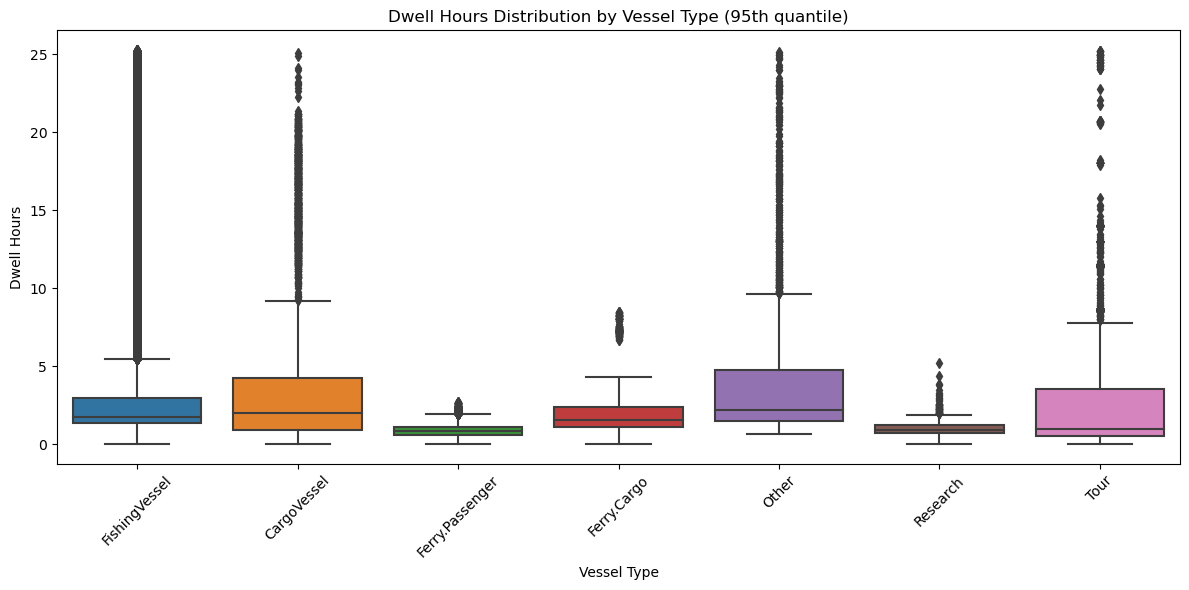

In [31]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=transponder_pings_merged_filtered, x='vessel_type', y='dwell_hours')
plt.xticks(rotation=45)
plt.title('Dwell Hours Distribution by Vessel Type (95th quantile)')
plt.xlabel('Vessel Type')
plt.ylabel('Dwell Hours')
plt.tight_layout()
plt.show()

Are fishing vessels staying longer than usual at certain ports?

Is a ferry showing suspiciously long dwell times (unusual)?

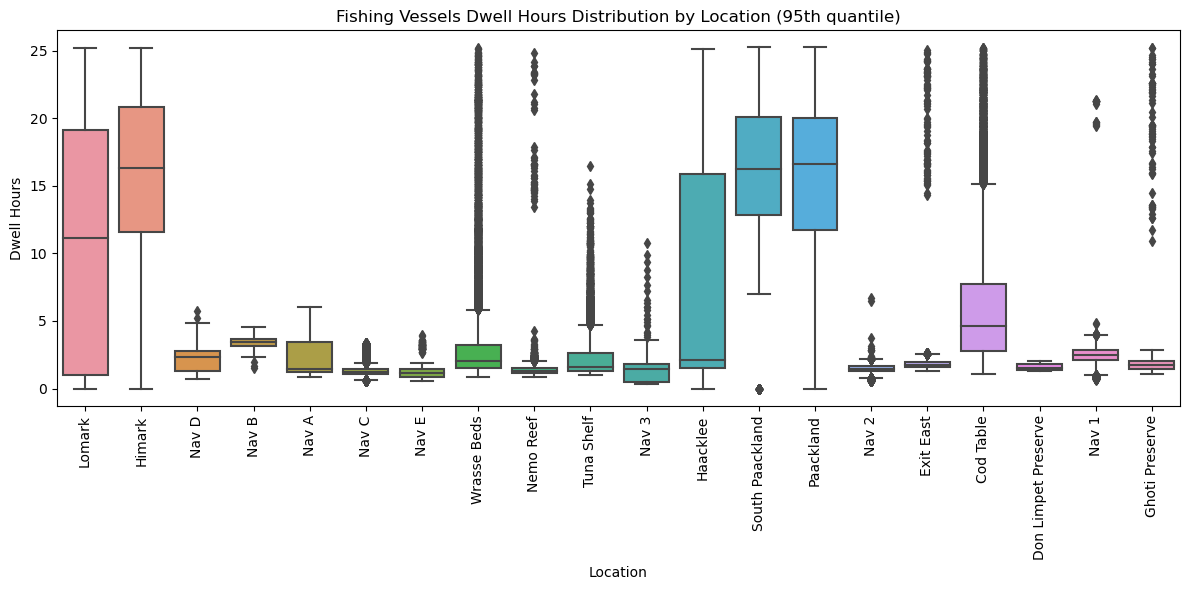

In [32]:
# Filtered for fishing-specific vessel types...

plt.figure(figsize=(12, 6))
sns.boxplot(
    data=transponder_pings_merged_filtered[transponder_pings_merged_filtered['vessel_type'].isin(['FishingVessel'])], 
    x='source', 
    y='dwell_hours')
plt.xticks(rotation=90)
plt.title('Fishing Vessels Dwell Hours Distribution by Location (95th quantile)')
plt.xlabel('Location')
plt.ylabel('Dwell Hours')
plt.tight_layout()
plt.show()

In [33]:
illegal_fishing_locations = ['Ghoti Preserve', 'Nemo Reef', 'Don Limpet Preserve']

In [198]:
# Memorize dwell statistics for illegal fishing locations
dwell_stats_illegal = transponder_pings_merged_filtered[transponder_pings_merged_filtered['source'].isin(illegal_fishing_locations)].groupby('source')['dwell_hours'].describe()

print(dwell_stats_illegal.to_string())

                       count      mean       std       min       25%       50%       75%        max
source                                                                                             
Don Limpet Preserve   1477.0  4.344208  5.242261  0.384552  1.163882  2.299481  4.055415  25.219676
Ghoti Preserve        2030.0  2.319914  3.955570  0.420601  0.732166  1.206794  1.699480  25.240568
Nemo Reef            19620.0  1.483502  1.161053  0.468503  1.164342  1.332496  1.537213  24.843433


In [34]:
# Filter and compute total dwell time per vessel
ranking_illegal_dwellers = (
    transponder_pings_merged[
        (transponder_pings_merged['source'].isin(illegal_fishing_locations)) &
        (transponder_pings_merged['vessel_type'] == 'FishingVessel')
    ]
    .groupby('target')['dwell_hours']
    .sum()
    .sort_values(ascending=False)
    .reset_index()
)

# Rename columns for clarity
ranking_illegal_dwellers.columns = ['Vessel ID', 'Total Dwell Time (hours)']

print("All Fishing Vessels ranked by Dwell Time in Illegal Fishing Locations:\n")
print(ranking_illegal_dwellers.to_string(index=True))

All Fishing Vessels ranked by Dwell Time in Illegal Fishing Locations:

                       Vessel ID  Total Dwell Time (hours)
0              bluefishbandit8ec               1441.268794
1            anchovyassaulterb1c               1293.728694
2         europeanperchpirated9b               1194.727124
3                 halibuthero9b9               1154.999549
4          yellowfintunataker08b                998.002294
5         welscatfishwrangler6ae                997.544130
6      chainpickerelplunderer039                980.943101
7                  soleseeker47a                968.534479
8               snooksnatcherbdb                965.141508
9          pacificcodcapturer81c                943.702406
10           herringharpooner843                913.986128
11             deepseadrifter9f2                859.764683
12              haddockhunter1a7                846.085657
13             bluegillbandita5f                802.346286
14               marlinmaster8ab           

In [35]:
fishing_vessel_ids = vessels[vessels['vessel_type'] == 'FishingVessel']['id']
pinged_vessel_ids = transponder_pings_merged[transponder_pings_merged['vessel_type'] == 'FishingVessel']['target'].unique()

print(f"All vessels have been pinged at least once since the pinged fishing vessels are {len(pinged_vessel_ids)} out of {len(fishing_vessel_ids)} fishing vessels.")

print(f"\nThe number of fishing vessels caught in illegal fishing locations are {len(ranking_illegal_dwellers)}.")

All vessels have been pinged at least once since the pinged fishing vessels are 178 out of 178 fishing vessels.

The number of fishing vessels caught in illegal fishing locations are 131.


Let's analyze **time gaps** between pings:

In [36]:
# Sort by vessel (target) and time
sorted_pings = transponder_pings_merged[transponder_pings_merged['vessel_type'] == 'FishingVessel'].sort_values(by=['target', 'time'])

# Compute end time of dwell
sorted_pings['end_time'] = sorted_pings['time'] + pd.to_timedelta(sorted_pings['dwell'], unit='s')

# Group by vessel and shift to get previous end_time
sorted_pings['prev_end'] = sorted_pings.groupby('target')['end_time'].shift()

# Calculate gap between pings (in seconds)
sorted_pings['gap'] = (sorted_pings['time'] - sorted_pings['prev_end']).dt.total_seconds()

# Remove negative or null values
sorted_pings['gap'] = sorted_pings['gap'].apply(lambda x: x if x and x > 0 else 0)

# Sum gaps per vessel (in hours)
gap_df = (
    sorted_pings
    .groupby('target')['gap']
    .sum()
    .div(3600)  # convert to hours
    .sort_values(ascending=False)
    .reset_index()
)

# Rename columns
gap_df.columns = ['vessel_id', 'total_gap_hours']

# Add ranking column (1-based index)
gap_df.index = gap_df.index + 1
gap_df.index.name = 'rank'

print("Top Vessels with Most Transponder Gaps (in hours):\n")
print(gap_df.round(2).to_string())

Top Vessels with Most Transponder Gaps (in hours):

                          vessel_id  total_gap_hours
rank                                                
1           longnosesuckerseeker6ab          1173.41
2                    tunatrawlerafd          1062.62
3                 musselmaraudere9b          1002.10
4            whitemarlinwranglerbac           843.02
5          europeaneelenthusiastf9f           837.81
6                 albacoreangler47d           777.25
7                  eelenthusiast8c6           769.07
8                    seaswindler255           741.91
9                 brinebuccaneer9fd           740.04
10         flatheadcatfishfindera51           735.90
11                 pikeplunderer0ca           734.50
12               laketroutlooter534           732.05
13         cutthroattroutcatchere2b           720.14
14            whitefishwhisperer6df           708.33
15         grasspickerelgangster7d1           707.49
16                   oceanreaper44a           6

/Users/matilde/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


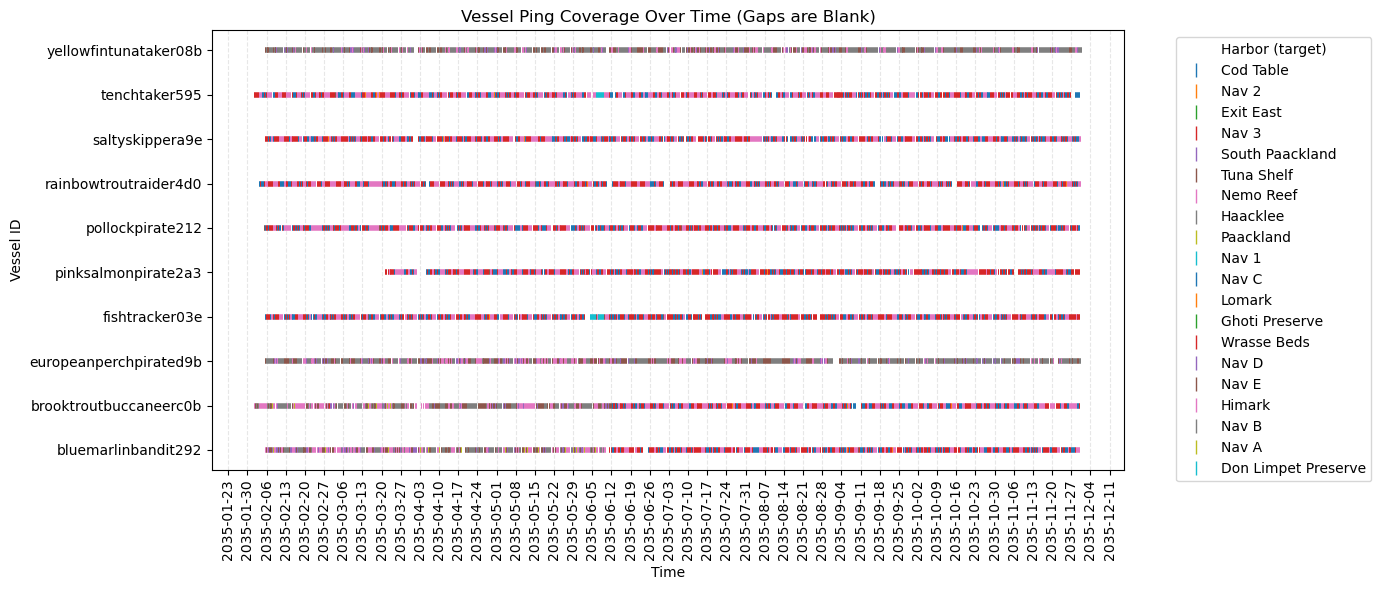

In [37]:
import matplotlib.dates as mdates

# Filter for top vessels with most gaps
top_gap_vessels = sorted_pings['target'].value_counts().head(10).index
timeline_data = sorted_pings[sorted_pings['target'].isin(top_gap_vessels)]
harbors = sorted_pings['source'].dropna().unique()
harbor_palette = dict(zip(harbors, sns.color_palette("tab10", len(harbors))))

# Assign a y-position to each vessel
vessel_to_y = {vessel: i for i, vessel in enumerate(timeline_data['target'].unique())}

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

for _, row in timeline_data.iterrows():
    y = vessel_to_y[row['target']]
    ax.hlines(y, row['time'], row['end_time'], colors=harbor_palette[row['source']], linewidth=4)

# Format y-axis with vessel IDs
ax.set_yticks(list(vessel_to_y.values()))
ax.set_yticklabels(list(vessel_to_y.keys()))
ax.set_ylabel('Vessel ID')

# Format x-axis as dates
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.title('Vessel Ping Coverage Over Time (Gaps are Blank)')
plt.xlabel('Time')
plt.xticks(rotation=90)
legend_handles = [
    plt.Line2D([0], [0], color=color, marker='|', linestyle='', markersize=10, label=harbor)
    for harbor, color in harbor_palette.items()
]
plt.legend(handles=legend_handles, title="Harbor (target)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.show()

Visualize route for two vessels...

In [38]:
# -------------------------------------------------------------------
# Prepare vessel data for timeline visualization
# -------------------------------------------------------------------
def prepare_vessel_data(sorted_pings: pd.DataFrame, vessel_id: str) -> tuple:
    """
    Filters and prepares vessel data for timeline visualization.

    Args:
        sorted_pings (pd.DataFrame): DataFrame containing pings with 'target', 'time', 'end_time', and 'source'.
        vessel_id (str): ID of the vessel to analyze.

    Returns:
        vessel_data_sorted (pd.DataFrame): Sorted DataFrame for the selected vessel.
        location_to_y (dict): Mapping of locations to y-axis positions.
    """
    # Filter for selected vessel and sort chronologically
    vessel_data = sorted_pings[sorted_pings['target'] == vessel_id]
    vessel_data_sorted = vessel_data.sort_values('time')

    # Build mapping: location -> y position
    locations = vessel_data_sorted['source'].dropna().unique()
    location_to_y = {loc: i for i, loc in enumerate(locations)}

    return vessel_data_sorted, location_to_y

Static visualization

In [39]:
# -------------------------------------------------------------------
# Static timeline visualization (Matplotlib)
# -------------------------------------------------------------------
def plot_vessel_timeline_static(vessel_data_sorted: pd.DataFrame, location_to_y: dict, harbor_palette: dict = None):
    """
    Generates a static Matplotlib timeline for vessel movements.

    Args:
        vessel_data_sorted (pd.DataFrame): Prepared vessel data sorted by time.
        location_to_y (dict): Mapping of locations to y-axis positions.
        harbor_palette (dict): Optional custom color palette per location.
    """
    harbor_palette = harbor_palette or {}
    fig, ax = plt.subplots(figsize=(14, 6))

    # Horizontal bars for stays at locations
    for _, row in vessel_data_sorted.dropna(subset=['time', 'end_time']).iterrows():
        y = location_to_y[row['source']]
        ax.hlines(
            y,
            row['time'],
            row['end_time'],
            colors=harbor_palette.get(row['source'], 'gray'),
            linewidth=6
        )

    # Transition lines between locations
    valid_rows = vessel_data_sorted.dropna(subset=['time', 'end_time'])
    times = valid_rows['end_time'].tolist()
    next_times = valid_rows['time'].tolist()[1:]
    ys = [location_to_y[src] for src in valid_rows['source']]
    next_ys = ys[1:]

    for i in range(len(times) - 1):
        ax.plot(
            [times[i], next_times[i]],
            [ys[i], next_ys[i]],
            color='black',
            alpha=0.2,
            linewidth=2,
            zorder=1
        )

    # Formatting
    ax.set_yticks(list(location_to_y.values()))
    ax.set_yticklabels(list(location_to_y.keys()))
    ax.set_ylabel('Location')
    ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    plt.title(f'Vessel Route Over Time: {vessel_data_sorted["name"].iloc[0]}')
    plt.xlabel('Time')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.grid(True, axis='x', linestyle='--', alpha=0.3)
    plt.show()

Interactive Visualization using **Altair**

In [40]:
# -------------------------------------------------------------------
# Interactive timeline visualization (Altair)
# -------------------------------------------------------------------
def plot_vessel_timeline_interactive(vessel_data_sorted: pd.DataFrame, location_to_y: dict):
    """
    Generates an interactive Altair timeline for vessel movements,
    highlighting overlaps between intervals.

    Args:
        vessel_data_sorted (pd.DataFrame): Prepared vessel data sorted by time.
        location_to_y (dict): Mapping of locations to y-axis positions.

    Returns:
        alt.Chart: Interactive Altair chart.
    """
    # Filter valid rows for timeline
    timeline = vessel_data_sorted.dropna(subset=['time', 'end_time']).copy()
    timeline['y'] = timeline['source'].map(location_to_y)

    # Horizontal bars for stays
    bars = alt.Chart(timeline).mark_bar().encode(
        x='time:T',
        x2='end_time:T',
        y=alt.Y('source:N', sort=list(location_to_y.keys()), title='Location'),
        color=alt.Color('source:N', legend=None),
        tooltip=['source', 'time', 'end_time', 'dwell_hours']
    )

    # Detect overlaps between intervals
    intervals = vessel_data_sorted.dropna(subset=['time', 'end_time'])[['time', 'end_time']].sort_values('time')
    overlaps = []
    for i in range(1, len(intervals)):
        prev_end = intervals.iloc[i-1]['end_time']
        curr_start = intervals.iloc[i]['time']
        if pd.notnull(prev_end) and pd.notnull(curr_start) and curr_start < prev_end:
            overlaps.append({'overlap_start': curr_start, 'overlap_end': prev_end})

    # Overlay overlapping intervals in red
    if overlaps:
        overlap_df = pd.DataFrame(overlaps)
        overlap_bars = alt.Chart(overlap_df).mark_bar(color='red', opacity=0.3).encode(
            x='overlap_start:T',
            x2='overlap_end:T',
            y=alt.value(0),
            y2=alt.value(len(location_to_y) - 1)
        )
        bars = bars + overlap_bars

    # Transition lines between locations
    lines = alt.Chart(timeline).mark_line(point=True).encode(
        x='time:T',
        y=alt.Y('source:N', sort=list(location_to_y.keys())),
        detail='target:N',
        color=alt.value('black'),
        opacity=alt.value(0.3)
    )

    # Combine chart layers
    chart = (bars + lines).properties(
        width=950,
        height=300,
        title=f'Vessel Route Over Time: {timeline["name"].iloc[0]}'
    )

    return chart.interactive()

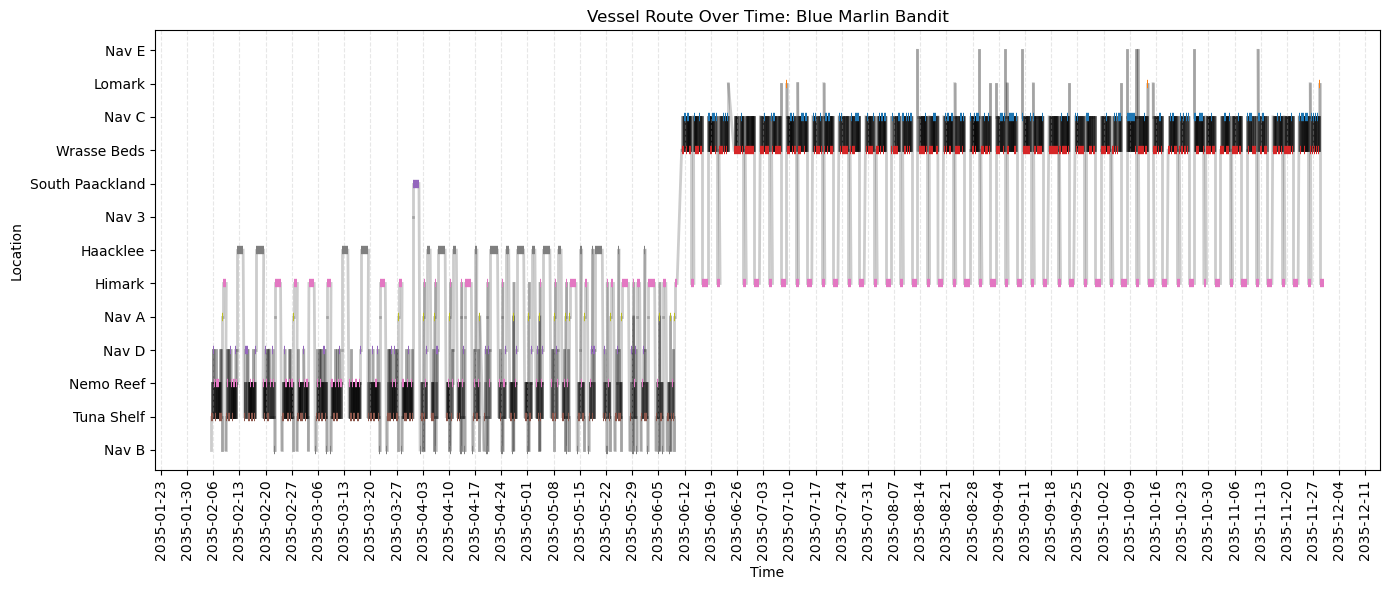

alt.LayerChart(...)

In [41]:
# Prepare vessel data
vessel_id = 'bluemarlinbandit292' # Example vessel ID
vessel_data_sorted, location_to_y = prepare_vessel_data(sorted_pings, vessel_id)

# Static visualization
plot_vessel_timeline_static(vessel_data_sorted, location_to_y, harbor_palette)

# Interactive visualization
chart = plot_vessel_timeline_interactive(vessel_data_sorted, location_to_y)
chart.display()

Let's analyze the **harbor visits** of fishing vessels:

In [42]:
# Count number of visits per vessel
harbor_visit_counts = (
    harbor_reports_merged[harbor_reports_merged['vessel_type'].isin(['FishingVessel'])]
    .groupby('source')
    .size()
    .sort_values(ascending=False)
    .reset_index()
)

print(harbor_visit_counts.to_string(index=True))

                            source   0
0                bluegillbandita5f  19
1           brooktroutbuccaneerc0b  18
2             whitefishwrangler7df  18
3              bluemarlinbandit292  16
4          arcticgraylingangler094  15
5                  musselmaster8d8  15
6                perchplundererbc0  15
7                  wavewranglerc2d  15
8                 herringhunter30b  14
9                marinemarauder8c9  14
10                 perchpursuer982  13
11            yellowperchpiratec59  13
12             pinksalmonpirate2a3  12
13                        huron1b3  12
14       tigermuskellungemaster012  11
15                 zanderzealotb23  11
16               mackerelmaster0a5  11
17                   kingfisher87d  11
18                  turbottakerd86  11
19       chainpickerelplunderer039  11
20                 saltyskippera9e  11
21                  flukefinder28d  11
22                   codcatcher04c  11
23           rainbowtroutraider4d0  11
24              walleyewr

In [43]:
top_vessels_per_visits = harbor_visit_counts['source'].head(10).to_list()

# Filter only top vessels
top_vessel_visits = harbor_reports_merged[harbor_reports_merged['source'].isin(top_vessels_per_visits)].copy()

# Ensure date is datetime
top_vessel_visits['date'] = pd.to_datetime(top_vessel_visits['date'])

In [44]:
import itertools

# Create a full date range from earliest to latest date
all_dates = pd.date_range(top_vessel_visits['date'].min(), top_vessel_visits['date'].max(), freq='D')

# Create a base DataFrame with all vessel-date combinations
full_index = pd.DataFrame(list(itertools.product(top_vessels_per_visits, all_dates)), columns=['source', 'date'])

# Merge with real harbor visit data
harbor_merged = full_index.merge(
    top_vessel_visits[['source', 'date', 'target']], 
    on=['source', 'date'],
    how='left'
)

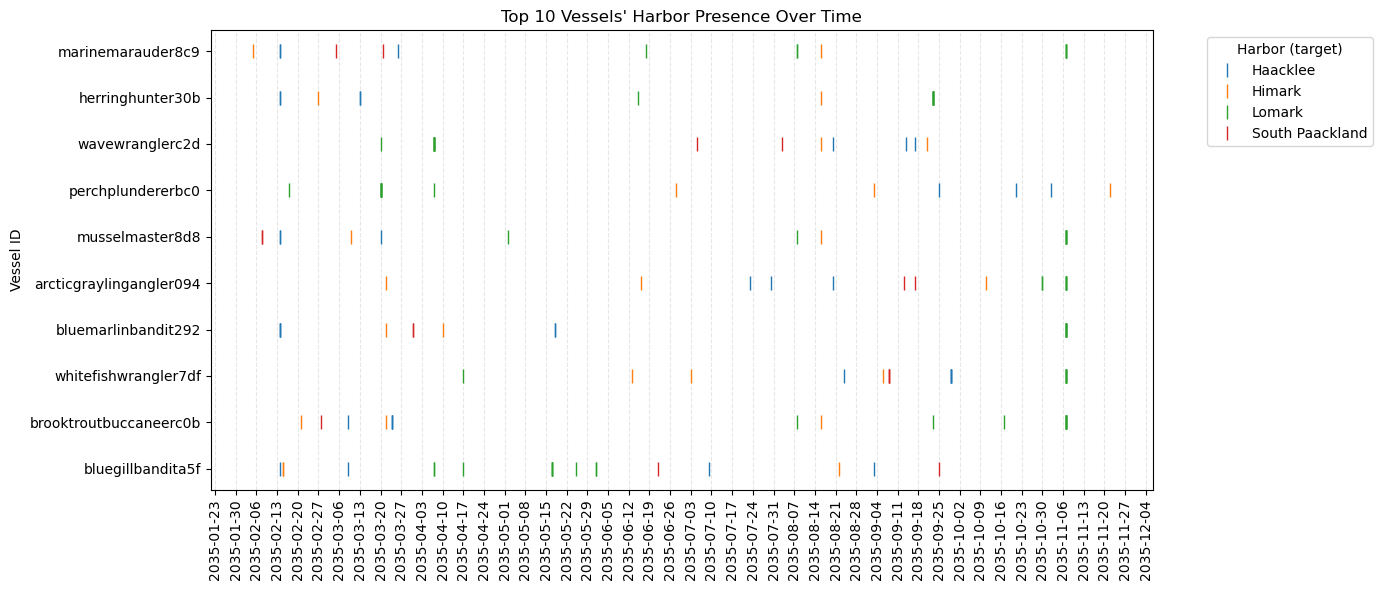

In [45]:
import matplotlib.dates as mdates

# Assign a numeric y-position to each vessel
vessel_to_y = {v: i for i, v in enumerate(top_vessels_per_visits)}
harbors = top_vessel_visits['target'].dropna().unique()
harbor_palette = dict(zip(harbors, sns.color_palette("tab10", len(harbors))))

# Plot
fig, ax = plt.subplots(figsize=(14, 6))

for _, row in top_vessel_visits.iterrows():
    if pd.notna(row['target']):
        y = vessel_to_y[row['source']]
        ax.plot(row['date'], y, marker='|', color=harbor_palette[row['target']], markersize=10)

# Y-axis labels
ax.set_yticks(list(vessel_to_y.values()))
ax.set_yticklabels(list(vessel_to_y.keys()))
ax.set_ylabel("Vessel ID")

# X-axis formatting
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=90)

plt.title("Top 10 Vessels' Harbor Presence Over Time")
legend_handles = [
    plt.Line2D([0], [0], color=color, marker='|', linestyle='', markersize=10, label=harbor)
    for harbor, color in harbor_palette.items()
]
plt.legend(handles=legend_handles, title="Harbor (target)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.show()


## Q1. Is there a way to associate cargo in **harbor transactions** with vessels to spot illegal behaviors? 

Let's define the **illegal fish species**: those species that can only be found in illegal fishing zones

In [58]:
# From locations and illegal_fishing_locations, get list of illegal fish species by intersecting locations['fish_species_present']
illegal_fishing_locations = ['Ghoti Preserve', 'Nemo Reef', 'Don Limpet Preserve']

fish_in_illegal_zones = set() # store fish species found in ILLEGAL fishing zones

for index, row in locations[locations['name'].isin(illegal_fishing_locations)].iterrows():
    fish_in_illegal_zones.update(row['fish_species_present'])
    print(f"Location: {row['name']}, Illegal Fish Species: {row['fish_species_present']}")

print(f"\nFish species found in ILLEGAL fishing zones:\n{fish_in_illegal_zones}")

Location: Ghoti Preserve, Illegal Fish Species: ['labridaenrefert9be', 'habeaspisces4eb', 'piscessatisb87', 'piscisosseusb6d']
Location: Nemo Reef, Illegal Fish Species: ['labridaenrefert9be', 'thunnininveradb7', 'piscesfrigus900', 'habeaspisces4eb', 'piscessatisb87']
Location: Don Limpet Preserve, Illegal Fish Species: ['thunnininveradb7', 'piscesfrigus900', 'habeaspisces4eb', 'piscessatisb87', 'piscesfoetidaae7']

Fish species found in ILLEGAL fishing zones:
{'piscesfrigus900', 'piscessatisb87', 'habeaspisces4eb', 'piscesfoetidaae7', 'labridaenrefert9be', 'thunnininveradb7', 'piscisosseusb6d'}


In [70]:
fish_in_legal_zones = set() # store fish species found in LEGAL fishing zones

for index, row in locations[~locations['name'].isin(illegal_fishing_locations)].iterrows():
    if row['fish_species_present'] == []:
        continue
    fish_in_legal_zones.update(row['fish_species_present'])
    print(f"Location: {row['name']}, Legal Fish Species: {row['fish_species_present']}")

print(f"\nFish species found in LEGAL fishing zones:\n{fish_in_legal_zones}")

Location: Cod Table, Legal Fish Species: ['gadusnspecificatae4ba', 'piscesfrigus900', 'habeaspisces4eb']
Location: Wrasse Beds, Legal Fish Species: ['labridaenrefert9be', 'piscesfrigus900', 'habeaspisces4eb']
Location: Tuna Shelf, Legal Fish Species: ['thunnininveradb7', 'piscesfrigus900', 'habeaspisces4eb', 'piscissapidum9b7']

Fish species found in LEGAL fishing zones:
{'piscesfrigus900', 'habeaspisces4eb', 'piscissapidum9b7', 'labridaenrefert9be', 'thunnininveradb7', 'gadusnspecificatae4ba'}


In [61]:
# illegal_fish_species are those NOT in intersection of fish_in_illegal_zones and fish_in_legal_zones
illegal_fish_species = fish_in_illegal_zones - fish_in_legal_zones
print(f"Illegal Fish Species (only in illegal fishing zones):\n{illegal_fish_species}")

Illegal Fish Species (only in illegal fishing zones):
{'piscessatisb87', 'piscesfoetidaae7', 'piscisosseusb6d'}


In [78]:
print(f"There are {len(transactions_merged[transactions_merged['commodity'].isin(illegal_fish_species)])} transactions involving illegal fish species out of {len(transactions_merged)} total transactions.")

There are 577 transactions involving illegal fish species out of 5307 total transactions.


Let's create a **color palette** to distinguish illegal fish species

In [121]:
sns.color_palette(palette='Reds') # For illegal fish species

[(0.9950634371395617, 0.8596539792387543, 0.7986620530565167),
 (0.9882352941176471, 0.6866743560169165, 0.5778854286812765),
 (0.9865897731641676, 0.5067281814686659, 0.38123798539023457),
 (0.9570011534025374, 0.3087120338331411, 0.22191464821222606),
 (0.8370472895040368, 0.13394848135332565, 0.13079584775086506),
 (0.6663437139561708, 0.06339100346020761, 0.08641291810841982)]

In [122]:
sns.color_palette(palette='Blues') # For other species

[(0.8584083044982699, 0.9134486735870818, 0.9645674740484429),
 (0.7309496347558632, 0.8394771241830065, 0.9213225682429834),
 (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 (0.32628988850442137, 0.6186236063052672, 0.802798923490965),
 (0.16696655132641292, 0.48069204152249134, 0.7291503267973857),
 (0.044059976931949255, 0.3338869665513264, 0.6244521337946944)]

In [135]:
# Color palette for commodities
commodity_names = transactions_merged['commodity'].unique()
illegal_palette = sns.color_palette("Reds", len([name for name in commodity_names if name in illegal_fish_species]))
legal_palette = sns.color_palette("Blues", len([name for name in commodity_names if name not in illegal_fish_species]))

commodity_palette = {}
illegal_idx = 0
legal_idx = 0

for name in commodity_names:
    if name in illegal_fish_species:
        commodity_palette[name] = illegal_palette[illegal_idx]
        illegal_idx += 1
    else:
        commodity_palette[name] = legal_palette[legal_idx]
        legal_idx += 1

In [136]:
commodity_palette

{'gadusnspecificatae4ba': (0.8702191464821223,
  0.9213225682429834,
  0.9685044213763937),
 'piscissapidum9b7': (0.7752402921953095,
  0.8583006535947711,
  0.9368242983467897),
 'habeaspisces4eb': (0.6172549019607844,
  0.7908650519031142,
  0.8818454440599769),
 'piscesfrigus900': (0.41708573625528644,
  0.6806305267204922,
  0.8382314494425221),
 'oncorhynchusrosea790': (0.25628604382929643,
  0.5700115340253749,
  0.7751633986928105),
 'piscisosseusb6d': (0.9882352941176471,
  0.732072279892349,
  0.6299269511726259),
 'piscesfoetidaae7': (0.9835755478662053,
  0.4127950788158401,
  0.28835063437139563),
 'labridaenrefert9be': (0.1271049596309112,
  0.4401845444059977,
  0.7074971164936563),
 'thunnininveradb7': (0.03137254901960784,
  0.3140945790080738,
  0.606489811610919),
 'piscessatisb87': (0.7925720876585928,
  0.09328719723183392,
  0.11298731257208766)}

Static visualization

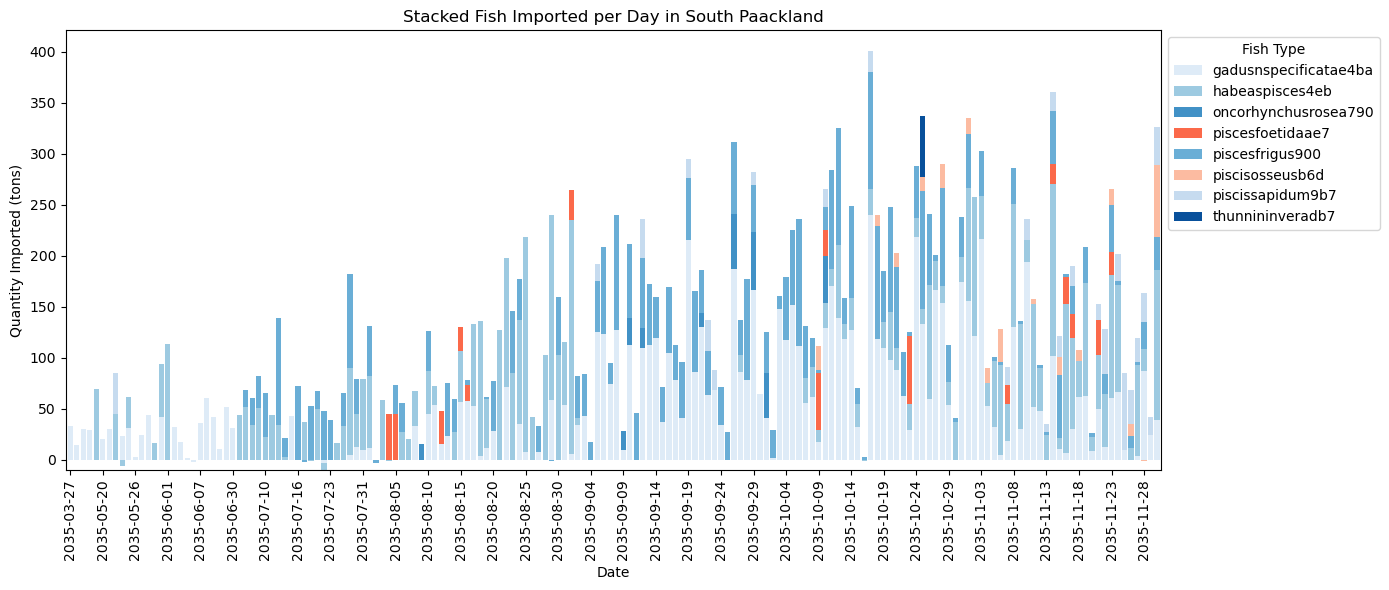

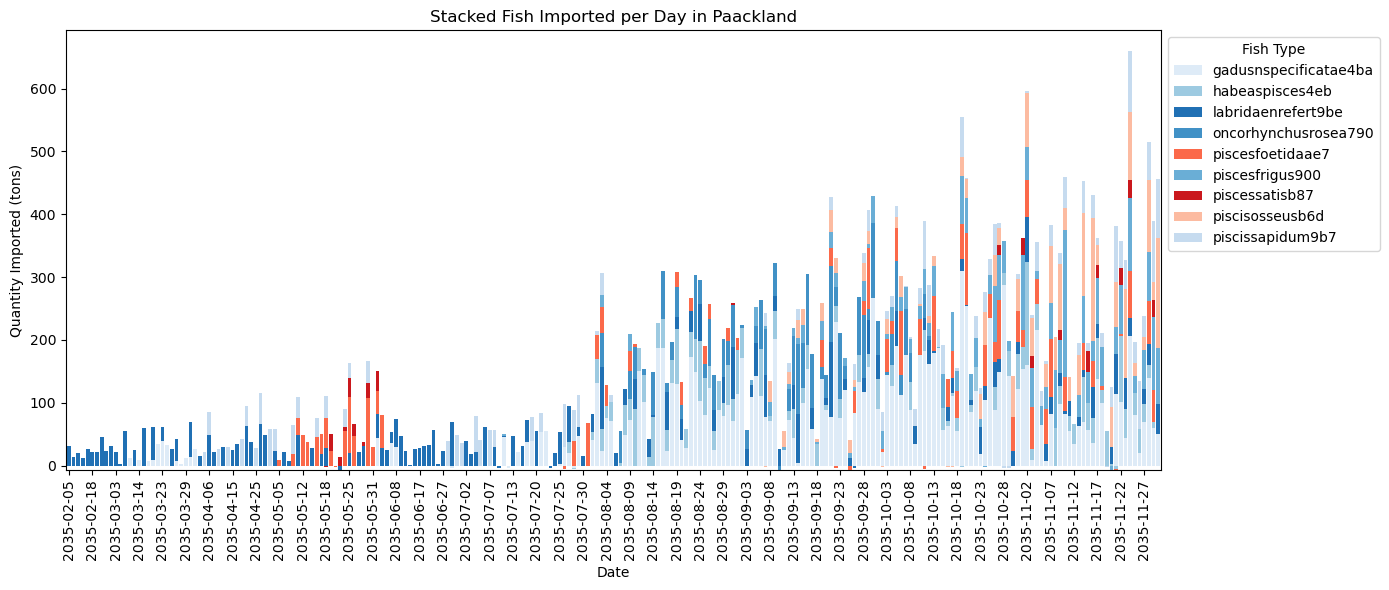

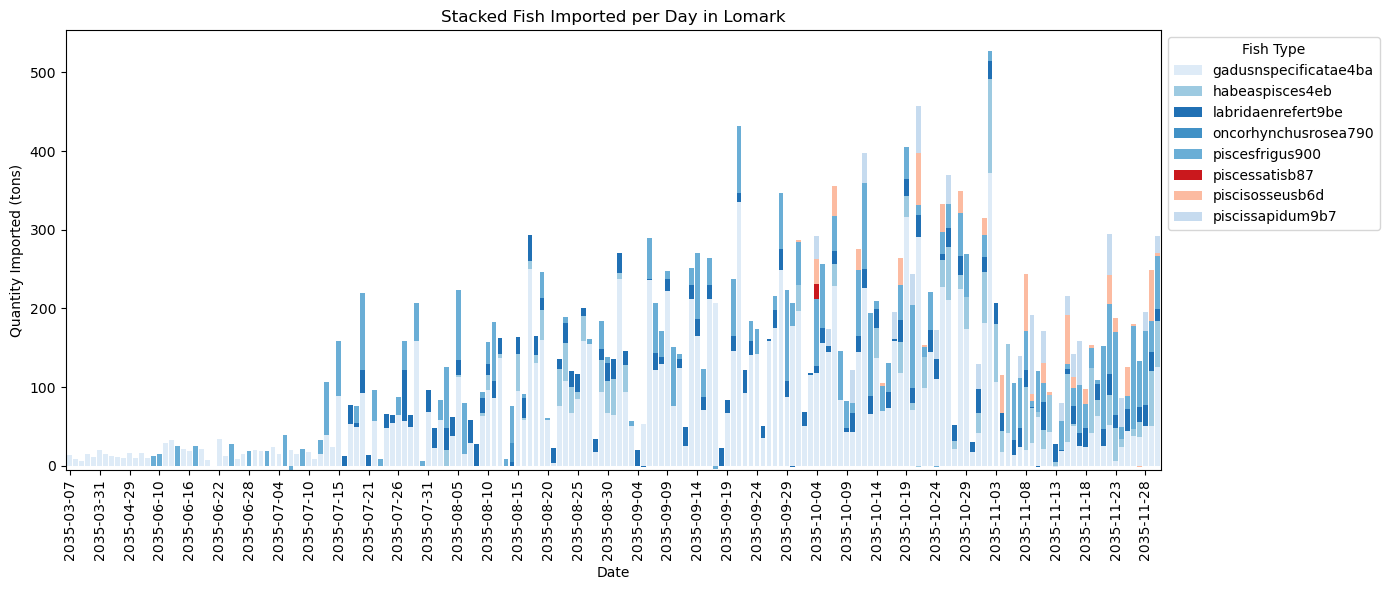

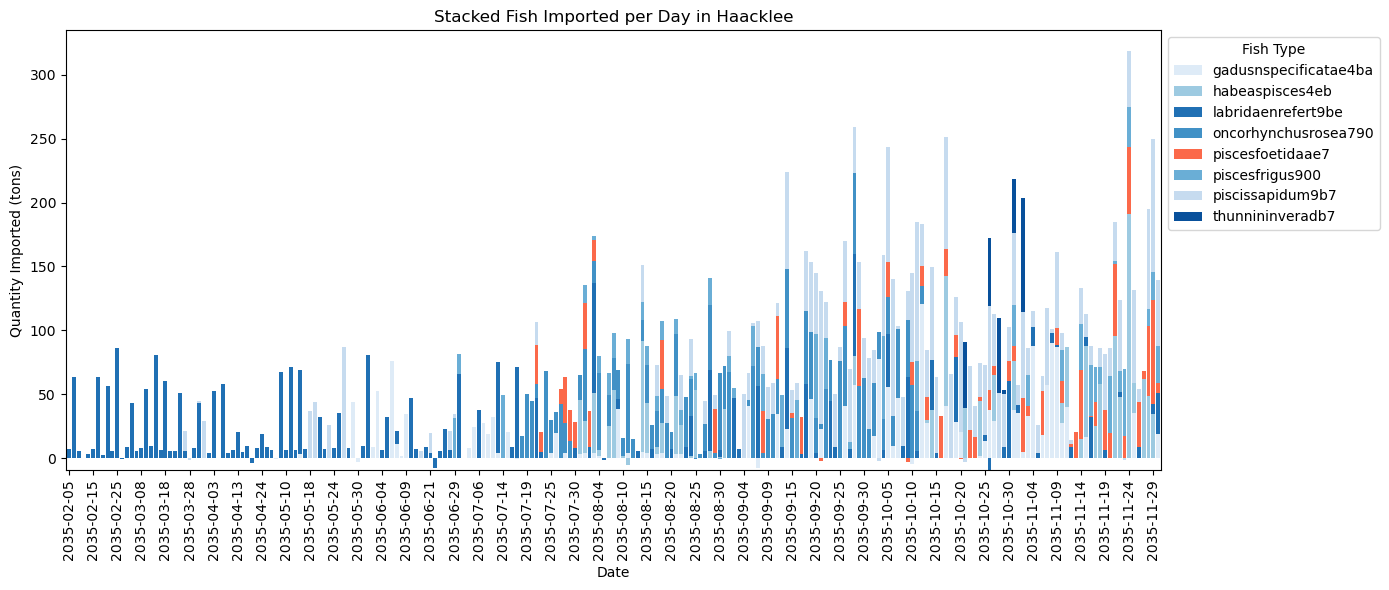

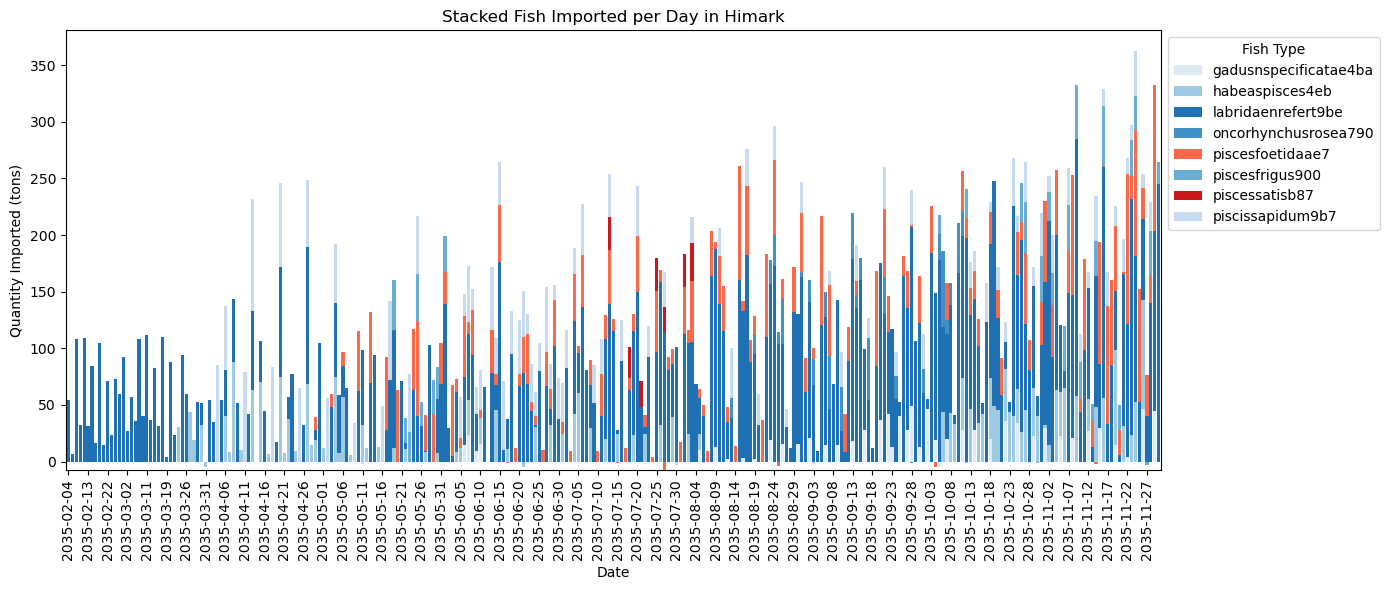

In [137]:
# Fixed plotting loop
for city in transactions_merged['target'].unique():
    city_data = transactions_merged[transactions_merged['target'] == city].copy()
    
    # Convert date to string for categorical x-axis
    city_data['date_str'] = city_data['date'].astype(str)
    
    # Aggregate qty by date_str and fish type
    agg = city_data.groupby(['date_str', 'commodity'])['qty_tons'].sum().unstack(fill_value=0)
    
    # Create color list in the same order as columns in agg
    colors = [commodity_palette.get(col, 'gray') for col in agg.columns]
    
    ax = agg.plot(kind='bar', stacked=True, figsize=(14,6), width=0.8, color=colors)
    
    plt.title(f'Stacked Fish Imported per Day in {city}')
    plt.xlabel('Date')
    plt.ylabel('Quantity Imported (tons)')
    
    # Get current x ticks and labels
    ticks = ax.get_xticks()
    labels = agg.index.to_list()
    
    # Show every 5th label, hide others
    step = 5
    ax.set_xticks(ticks[::step])
    ax.set_xticklabels(labels[::step], rotation=90)
    
    plt.legend(title='Fish Type', bbox_to_anchor=(1,1), loc='upper left')
    plt.tight_layout()
    plt.show()

An interactive visualization using Altair

In [149]:
# Create color scale from the commodity_palette dictionary and convert colors to hex format for Altair
commodity_color_scale = alt.Scale(
    domain=list(commodity_palette.keys()),
    range=[f'#{int(r*255):02x}{int(g*255):02x}{int(b*255):02x}' 
           for r, g, b in commodity_palette.values()]
)

# Create a selection point for interactivity
highlight = alt.selection_point(fields=['commodity'], bind='legend')

for city in transactions_merged['target'].unique():
    city_data = transactions_merged[transactions_merged['target'] == city].copy()
    
    # Aggregate quantity per date and fish type
    agg = city_data.groupby(['date', 'commodity'], as_index=False)['qty_tons'].sum()
    
    # Create Altair stacked bar chart
    chart = alt.Chart(agg).mark_bar(size=2.5).encode(
        x=alt.X('date:T', title='Date'),
        y=alt.Y('qty_tons:Q', stack='zero', title='Quantity Imported (tons)'),
        color=alt.condition(
            highlight,
            alt.Color(
                'commodity:N',
                title='Fish Type',
                legend=alt.Legend(
                    orient="right",
                    columns=1,
                    title="Fish Type",
                    labelFontSize=12,
                    titleFontSize=14
                ),
                scale=commodity_color_scale
            ),
            alt.value('lightgray') # grey if not selected
        ),
        tooltip=[
            alt.Tooltip('date:T', title='Date'),
            alt.Tooltip('commodity:N', title='Fish Type'),
            alt.Tooltip('qty_tons:Q', title='Quantity (tons)')
        ]
    ).properties(
        width=800,
        height=300,
        title=f'Stacked Fish Imported per Day in {city}'
    ).add_params(
        highlight
    ).interactive()  # enables zoom and pan

    chart.display()

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

Let's now associate the Vessel with their probable cargos...

IF:
> A **VESSEL** is docked in a **HARBOR** where **ILLEGAL FISH SPECIES** was exported (1 day after delivery!)...

AND:
> ...**ILLEGAL FISH SPECIES** is present in a **ILLEGAL REGION** where **VESSEL** had been

THEN:
> **ILLEGAL FISH SPECIES** is probably **VESSEL**'s cargo!

In [ ]:
# Value counts of illegal fish species in transactions_merged
transactions_merged[transactions_merged['commodity'].isin(illegal_fish_species)]['commodity'].value_counts()

commodity
piscesfoetidaae7    400
piscisosseusb6d     150
piscessatisb87       27
Name: count, dtype: int64

In [208]:
# Initialize an empty column
transactions_merged['suspected_vessels'] = None

for index, row in transactions_merged.iterrows():
    harbor = row['target']
    date = row['date']
    qty_tonnage = row['qty_tons']

    # Step 1 — Find matching vessels in the harbor reports
    matches = harbor_reports_merged[
        (harbor_reports_merged['target'] == harbor) &
        (harbor_reports_merged['date'] == date - pd.Timedelta(days=1)) &
        (harbor_reports_merged['tonnage'] >= qty_tonnage) &
        (harbor_reports_merged['vessel_type'].isin(['FishingVessel', 'CargoVessel', 'Other']))
    ]

    # Step 2 — Find vessels that have been in illegal fishing locations
    dwell_thresholds = dwell_stats_illegal['75%']
    
    matches_pings = transponder_pings[
        transponder_pings['target'].isin(matches['source']) &
        transponder_pings['source'].isin(illegal_fishing_locations) &
        (transponder_pings['time'].dt.date < date.date()) &
        (transponder_pings['dwell_hours'] > transponder_pings['source'].map(dwell_thresholds))
    ]

    # Step 3 — Record the unique list of vessel names in a new column
    transactions_merged.at[index, 'suspected_vessels'] = matches_pings['target'].unique().tolist()

    # Progress bar
    if (index + 1) % 100 == 0:
        print(f"Processed {index + 1} / {len(transactions_merged)} transactions")

Processed 100 / 5307 transactions
Processed 200 / 5307 transactions
Processed 300 / 5307 transactions
Processed 400 / 5307 transactions
Processed 500 / 5307 transactions
Processed 600 / 5307 transactions
Processed 700 / 5307 transactions
Processed 800 / 5307 transactions
Processed 900 / 5307 transactions
Processed 1000 / 5307 transactions
Processed 1100 / 5307 transactions
Processed 1200 / 5307 transactions
Processed 1300 / 5307 transactions
Processed 1400 / 5307 transactions
Processed 1500 / 5307 transactions
Processed 1600 / 5307 transactions
Processed 1700 / 5307 transactions
Processed 1800 / 5307 transactions
Processed 1900 / 5307 transactions
Processed 2000 / 5307 transactions
Processed 2100 / 5307 transactions
Processed 2200 / 5307 transactions
Processed 2300 / 5307 transactions
Processed 2400 / 5307 transactions
Processed 2500 / 5307 transactions
Processed 2600 / 5307 transactions
Processed 2700 / 5307 transactions
Processed 2800 / 5307 transactions
Processed 2900 / 5307 transac

In [ ]:
# Assign the suspected vessels back to the original transactions DataFrame
transactions['suspected_vessels'] = transactions_merged['suspected_vessels']

In [211]:
transactions

,source,target,date,suspected_vessels
0,cargo_2035_2394778c,South Paackland,2035-11-03,[albacoreangler47d]
1,cargo_2035_23956ba0,South Paackland,2035-08-16,[]
2,cargo_2035_23957cfd,South Paackland,2035-08-20,[]
3,cargo_2035_23958501,Paackland,2035-11-07,[]
4,cargo_2035_23959ab6,South Paackland,2035-08-24,[]
...,...,...,...,...
5302,cargo_2035_3119010f,Paackland,2035-08-24,"[bonefishbaiter565, tunatrawlerafd]"
5303,cargo_2035_3119118e,Paackland,2035-08-25,[]
5304,cargo_2035_3119237c,Paackland,2035-08-28,[fishfinderb9d]
5305,cargo_2035_311936c4,Paackland,2035-08-30,"[baitedbreath538, dolphindasher004]"


Convert to JSON and save the file

In [218]:
transactions.to_json("../data/transactions.json", orient='records', date_format='iso', indent=2)

# SouthSeafood Express Corp

In [150]:
# Filter nodes for SouthSeafood Express Corp
southseafood_vessels = vessels.query("company == 'SouthSeafood Express Corp'")

print("Vessels of SouthSeafood Express Corp:")
print(southseafood_vessels.to_string())

Vessels of SouthSeafood Express Corp:
                     id    vessel_type              name flag_country                    company  tonnage  length_overall
60   snappersnatcher7be  FishingVessel  Snapper Snatcher      Oceanus  SouthSeafood Express Corp    100.0            20.0
174      roachrobberdb6  FishingVessel      Roach Robber      Oceanus  SouthSeafood Express Corp  11700.0           130.0


In [151]:
ranking_illegal_dwellers[ranking_illegal_dwellers['Vessel ID'].isin(southseafood_vessels['id'])]

,Vessel ID,Total Dwell Time (hours)
79,snappersnatcher7be,235.258558


In [152]:
gap_df[gap_df['vessel_id'].isin(southseafood_vessels['id'])]

,vessel_id,total_gap_hours
rank,,
173,roachrobberdb6,187.134436
175,snappersnatcher7be,119.910119


In [153]:
harbor_visit_counts[harbor_visit_counts['source'].isin(southseafood_vessels['id'])]

,source,0
59,roachrobberdb6,9
141,snappersnatcher7be,6


Visualize transactions where southseafood_vessels are among suspected_vessels

In [217]:
print(transactions_merged[transactions_merged['suspected_vessels'].apply(lambda x: any(v in southseafood_vessels['id'].values for v in x) if x else False)].to_string())

                   source  target       date  qty_tons              commodity                                                                                                 suspected_vessels
4203  cargo_2035_29642536  Lomark 2035-03-21      15.0  gadusnspecificatae4ba  [channelcatfishcapturer175, catfishcapturer7a8, snappersnatcher7be, northernpikepirated97, chumsalmoncatcher41e]


Visualize route

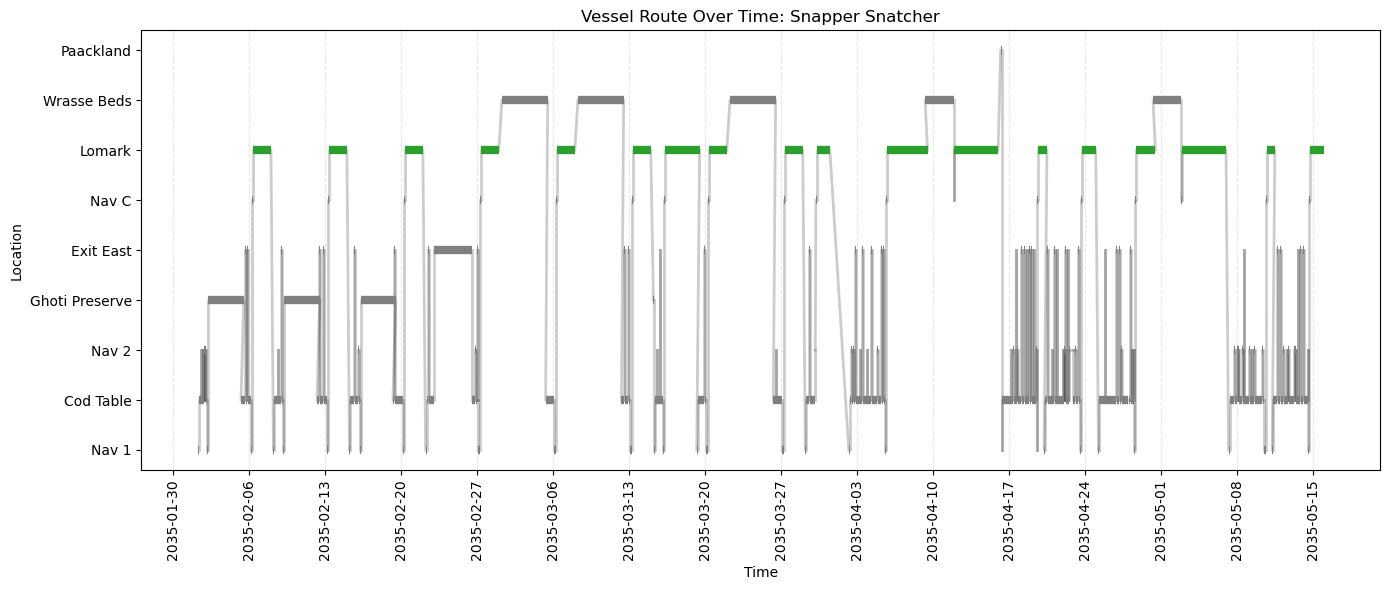

alt.LayerChart(...)

In [ ]:
# Prepare vessel data
vessel_id = 'snappersnatcher7be'
vessel_data_sorted, location_to_y = prepare_vessel_data(sorted_pings, vessel_id)

# Interactive visualization
chart = plot_vessel_timeline_interactive(vessel_data_sorted, location_to_y)
chart.display()

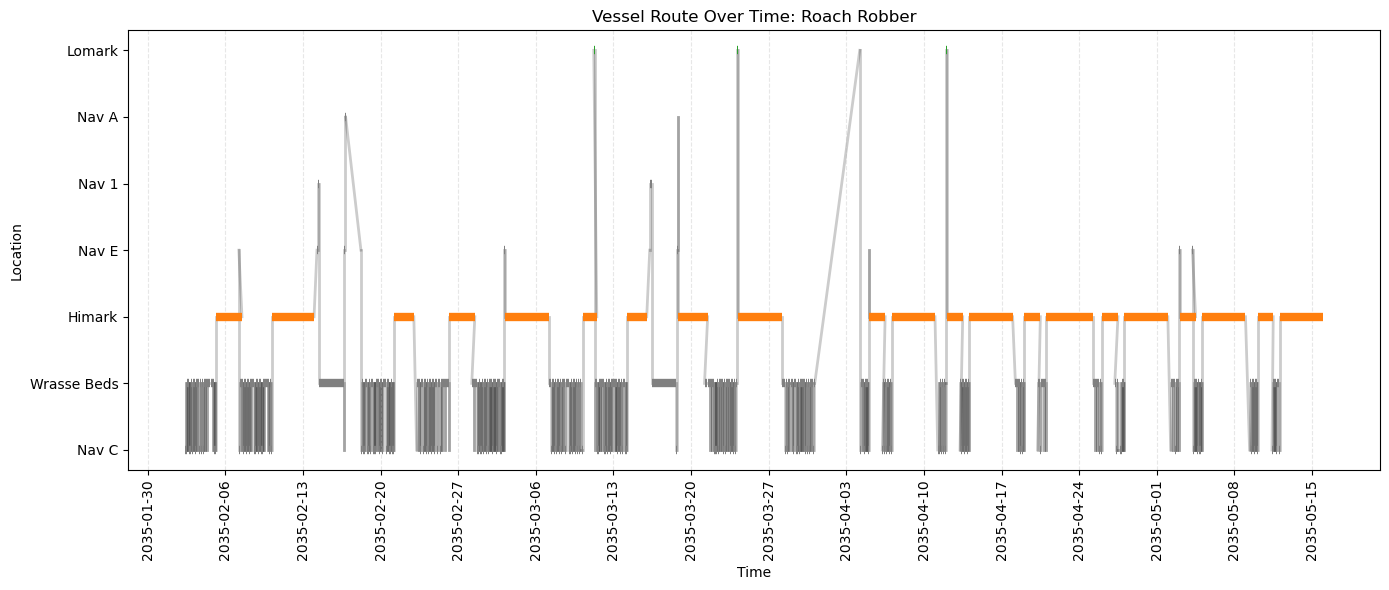

alt.LayerChart(...)

In [155]:
# Prepare vessel data
vessel_id = 'roachrobberdb6'
vessel_data_sorted, location_to_y = prepare_vessel_data(sorted_pings, vessel_id)

# Static visualization
plot_vessel_timeline_static(vessel_data_sorted, location_to_y, harbor_palette)

# Interactive visualization
chart = plot_vessel_timeline_interactive(vessel_data_sorted, location_to_y)
chart.display()

## We can now try to spot suspicious behaviors

### 1. Was a vessel docked with no ping?

Sometimes, vessels may appear in **harbor reports** but are **missing transponder data** for the same time and location. Transponders are supposed to be always on — if a ship is docked but has no ping, it could mean the transponder was turned off intentionally (e.g., suspicious behavior).

### 2. Was a fish delivery preceded by a vessel visit?

If a harbor records a fish delivery, ideally a **vessel visit should have occurred just before**.

### 3. Transponder says vessel was far, but harbor report says it was docked

Sometimes, transponder data shows a vessel far away, while a harbor report claims it was present locally. It could indicate **spoofing** (fake transponder signal), identity fraud, or data tampering.